In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import os
import matplotlib.gridspec as gridspec
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import fftpack

plt.rcParams.update({                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    })

--------------------------------

# Results


### PINN: 

Network: [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]

Num Param: 3.06k

Error u: 4.226821e-03

Error v: 1.519913e-02

Error lambda_1 (Clean Data): 0.08334%

Error lambda_2 (Clean Data): 5.83437%

Error lambda_1 (Noisy Data): 0.07727%

Error lambda_2 (Noisy Data): 5.48151%


### QRes: 

Network: [3, 14, 14, 14, 14, 14, 14, 14, 14, 2]

Num Param: 3.00k

Error u: 3.718566e-03

Error v: 1.026947e-02

Error lambda_1 (Clean Data): 0.04301%

Error lambda_2 (Clean Data): 4.28149% 

Error lambda_1 (Noisy Data): 0.05023%

Error lambda_2 (Noisy Data): 4.94165%


### PINN-lite: 

Network: [3, 20, 20, 20, 20, 2]

Num Param: 1.38k

Error u: 1.411763e-02

Error v: 3.499409e-02

Error lambda_1 (Clean Data): 0.67631%

Error lambda_2 (Clean Data): 8.97022%

Error lambda_1 (Noisy Data): 0.61181%

Error lambda_2 (Noisy Data): 8.39805%


### QRes-lite: 

Network: [3, 14, 14, 14, 14, 2]

Num Param: 1.37k

Error u: 9.678330e-03

Error v: 2.347274e-02

Error lambda_1 (Clean Data): 0.54597%

Error lambda_2 (Clean Data): 7.34631%

Error lambda_1 (Noisy Data): 0.83765%

Error lambda_2 (Noisy Data): 7.94320%


-----------------------------------------------

## Count Number of Parameters

In [2]:
l = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
num_param = 0
for i in range(len(l)-1):
    num_param += l[i] * l[i+1] + l[i+1]
print("PINN-full Num params: %.2fk" % np.round(num_param / 1000, 2))

PINN-full Num params: 3.06k


In [3]:
l = [3, 14, 14, 14, 14, 14, 14, 14, 14, 2]
num_param = 0
for i in range(len(l)-1):
    num_param += l[i] * l[i+1] * 2 + l[i+1]
print("QRes-full Num params: %.2fk" % np.round(num_param / 1000, 2))

QRes-full Num params: 3.00k


In [4]:
l = [3, 20, 20, 20, 20, 2]
num_param = 0
for i in range(len(l)-1):
    num_param += l[i] * l[i+1] + l[i+1]
print("PINN-lite Num params: %.2fk" % np.round(num_param / 1000, 2))

PINN-lite Num params: 1.38k


In [5]:
l = [3, 14, 14, 14, 14, 2]
num_param = 0
for i in range(len(l)-1):
    num_param += l[i] * l[i+1] * 2 + l[i+1]
print("QRes-lite Num params: %.2fk" % np.round(num_param / 1000, 2))

QRes-lite Num params: 1.37k


# Plotting

In [6]:
path_qres = 'saved/qres'
path_pinn = 'saved/pinn'

## Load Checkpoints

In [7]:
qres_saved = glob(path_qres+ '/p_pred_qres_lite*')
pinn_saved = glob(path_pinn+ '/p_pred_nn_lite*')

qres_plot, pinn_plot = dict(), dict()

for file in qres_saved:
    fn = file.split('_')[-1]
    epoch = fn.split('.')[0]
    file_pinn = path_pinn + '/p_pred_nn_lite_' + fn

    if epoch == 'final':
        qres_plot[100] = file
        pinn_plot[100] = file_pinn
    else:
        qres_plot[int(epoch[:-1])] = file
        pinn_plot[int(epoch[:-1])] = file_pinn

## The Ground Truth 

In [8]:
def real_pressure():
    # Load Data
    data = scipy.io.loadmat('../Data/cylinder_nektar_wake.mat')
        
    P_star = data['p_star'] # N x T
    snap = np.array([100])
    p_star = P_star[:,snap]
    return p_star

## Plot Exact Pressure Field

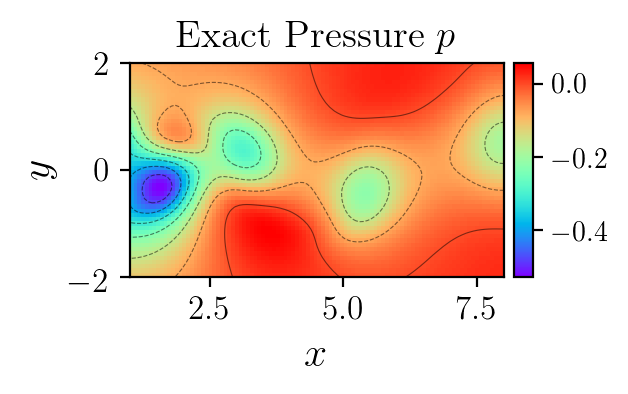

In [9]:
fig, ax = plt.subplots(dpi=200, figsize=(2.6, 1.5))

p_true = real_pressure()
p_true -= p_true.mean()

p_true = real_pressure()
p_true_2d = p_true.reshape(50, 100)
h = ax.imshow(p_true_2d, cmap='rainbow', extent=[1.0, 8.0, -2.0, 2.0])
ax.contour(np.flip(p_true_2d, axis=0), colors='black', linewidths=0.4, extent=[1.0, 8.0, -2.0, 2.0], alpha=0.5)
ax.set_title('Exact Pressure $p$', fontsize=14)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.tick_params(axis='both', labelsize=12)

fig.savefig("figures/Navier_Stoke_exact_p.pdf", dpi=300, bbox_inches = 'tight')
# fig.tight_layout()
plt.show()

## Error Map

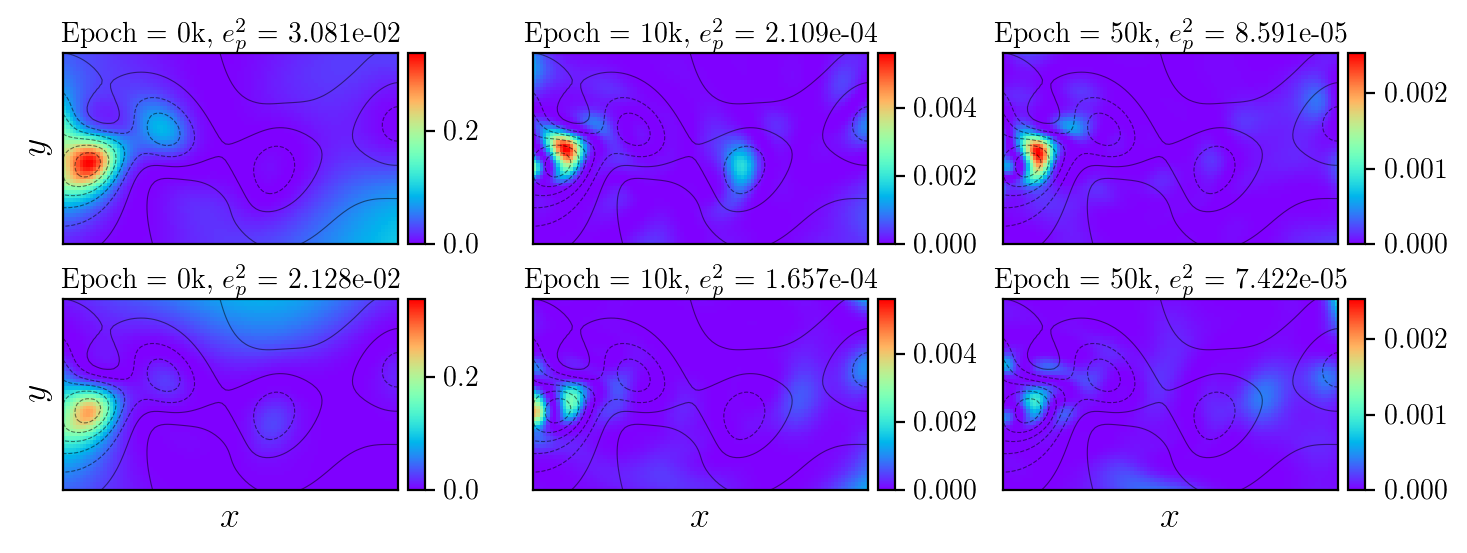

In [10]:
p_true = real_pressure()
p_true_2d = p_true.reshape(50, 100)
p_true_2d -= p_true_2d.mean()

epochs = [ 0, 10, 50 ]

fig, axes = plt.subplots(2, len(epochs), dpi=200, figsize=(len(epochs) * 2.8, 3.8))
for i in range(len(epochs)):   
    epoch = epochs[i]

    p_pinn = np.load(pinn_plot[epoch]).reshape(50, 100)
    p_qres = np.load(qres_plot[epoch]).reshape(50, 100)
    p_qres -= p_qres.mean()
    p_pinn -= p_pinn.mean()
    err_pinn = (p_pinn - p_true_2d) ** 2
    err_qres = (p_qres - p_true_2d) ** 2
    
    cmap = 'rainbow'
    
    vmax = max(err_pinn.max(), err_qres.max())
    
    h = axes[0, i].imshow(err_pinn, cmap=cmap, extent=[1.0, 8.0, -2.0, 2.0], vmin=0, vmax=vmax)
    axes[0, i].contour(np.flip(p_true_2d, axis=0), colors='black', linewidths=0.4, extent=[1.0, 8.0, -2.0, 2.0], alpha=0.5)
    axes[0, i].set_title("Epoch = %sk, $e_p^2$ = %.3e" % (epoch, err_pinn.mean()), fontsize=10, pad=0.05)
    axes[0, i].set_xticks([]) 
    axes[0, i].set_yticks([])
    divider = make_axes_locatable(axes[0, i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    h = axes[1, i].imshow(err_qres, cmap=cmap, extent=[1.0, 8.0, -2.0, 2.0], vmin=0, vmax=vmax)
    axes[1, i].set_title("Epoch = %sk, $e_p^2$ = %.3e" % (epoch, err_qres.mean()), fontsize=10, pad=0.05)
    axes[1, i].contour(np.flip(p_true_2d, axis=0), colors='black', linewidths=0.4, extent=[1.0, 8.0, -2.0, 2.0], alpha=0.5)
    axes[1, i].set_xticks([]) 
    axes[1, i].set_yticks([]) 
    axes[1, i].tick_params(labelsize=6) 
    divider = make_axes_locatable(axes[1, i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
axes[0, 0].set_ylabel('$y$', fontsize=13)
axes[1, 0].set_ylabel('$y$', fontsize=13) 

for i in range(len(epochs)):
    axes[1, i].set_xlabel('$x$', fontsize=13) 
    
fig.subplots_adjust(hspace=-0.25, wspace=0.3)
fig.savefig("figures/Navier_Stoke_error_map.pdf", dpi=300, bbox_inches = 'tight')

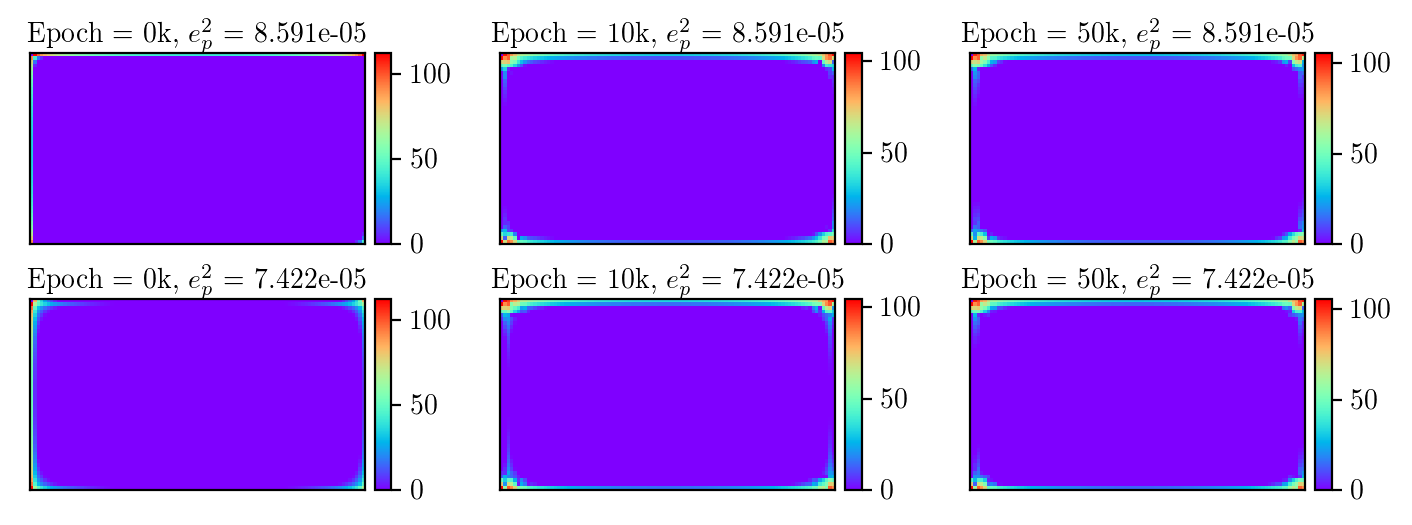

In [20]:
p_true = real_pressure()
p_true_2d = p_true.reshape(50, 100)
p_true_2d -= p_true_2d.mean()

epochs = [ 0, 10, 50 ]

fig, axes = plt.subplots(2, len(epochs), dpi=200, figsize=(len(epochs) * 2.8, 3.8))
for i in range(len(epochs)):   
    epoch = epochs[i]
    p_pinn = np.load(pinn_plot[epoch]).reshape(50, 100)
    p_qres = np.load(qres_plot[epoch]).reshape(50, 100)
    p_qres -= p_qres.mean()
    p_pinn -= p_pinn.mean()
    spec_pinn = 20 * np.log(np.abs(fftpack.fft2(p_pinn)))
    spec_qres = 20 * np.log(np.abs(fftpack.fft2(p_qres)))
    
    cmap = 'rainbow'
    
    vmax = max(spec_pinn.max(), spec_qres.max())
    
    h = axes[0, i].imshow(spec_pinn, cmap=cmap, extent=[1.0, 8.0, -2.0, 2.0], vmin=0, vmax=vmax)
    axes[0, i].set_title("Epoch = %sk, $e_p^2$ = %.3e" % (epoch, err_pinn.mean()), fontsize=10, pad=0.05)
    axes[0, i].set_xticks([]) 
    axes[0, i].set_yticks([])
    divider = make_axes_locatable(axes[0, i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    h = axes[1, i].imshow(spec_qres, cmap=cmap, extent=[1.0, 8.0, -2.0, 2.0], vmin=0, vmax=vmax)
    axes[1, i].set_title("Epoch = %sk, $e_p^2$ = %.3e" % (epoch, err_qres.mean()), fontsize=10, pad=0.05)
    axes[1, i].set_xticks([]) 
    axes[1, i].set_yticks([]) 
    axes[1, i].tick_params(labelsize=6) 
    divider = make_axes_locatable(axes[1, i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
fig.subplots_adjust(hspace=-0.25, wspace=0.3)
fig.savefig("figures/Navier_Stoke_error_map.pdf", dpi=300, bbox_inches = 'tight')